# Reading NetCDF's using Xarray to Pandas DataFrame
## Satellite Image Processing / BioCAST Seed Creation

Includes references to plotting using Matplotlib and related tools.

This program reads in two inputs: 1) APS level 4 satellite image 7 Day composite 2) BioCast generated advection product.  Both are NetCDF's.
The program's goal is to read the inputs, store them, and perform a union of the data with a basic gaussian smoothing to create a "full" image (sometimes a problem due to cloud coverage).
Output the data using NetCDF Best Practices, APS meta-data as an authoritative source, and custom meta-data geared towards future requirements.

## *Xarray*

007 reads a NetCDF via the netCDF4 library which appears to present no real problems.  Whether due to lack of understanding, skill or design moving a NetCDF into a Panda's Dataframe, as presented in this work, is cumbersome.  Xarray is to multi-dimensional data what Pandas is to 1D/2D data.  Xarray provides very strong convenience routines as well.

http://xarray.pydata.org/en/stable/index.html

xarray: N-D labeled arrays and datasets in Python

xarray (formerly xray) is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!

Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures.

Xarray is inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with dask for parallel computing.

## Project Setup

In [1]:
# Let's define some variables (information holders) for our project overall
# If using GCP or a similar Cloud Service Provider (CSP), you might be required
# to provide project details.

global PROJECT_ID, BUCKET_NAME, LOCATION
BUCKET_NAME =""
PROJECT_ID  =""
LOCATION    =""

BOLD_START="\033[1m"
BOLD_END="\033[0m"

Import Base Libraries

In [2]:
# Import key libraries necessary to support dynamic installation of additional libraries
# Use subprocess to support running operating system commands from the program, using the "bang" (!)
# symbology is supported, however that does not translate to an actual python script, this is a more
# agnostic approach.
###########################################
#- Minimal imports to start
###########################################
try:
    import sys
    import subprocess
    import importlib.util
    import atexit
    import os
except ImportError as e:
    print("There was a problem importing the most basic libraries necessary for this code.")
    print(repr(e))
    raise SystemExit("Stop right there!")

###########################################
#- Final Exit Routine
###########################################
@atexit.register
def goodbye():
    print("GOODBYE")

## Load Minimally Required Libraries

In [3]:
libraries=["numpy", "pandas", "scipy", "sklearn", "matplotlib", "seaborn", "cartopy",
           "rich", "rich[jupyter]", "unidecode", "icecream",
           "polars[all]", "dask[complete]", "xarray", "netCDF4",
           "tqdm", "watermark",
           "Pillow",]

import importlib.util

for library in libraries:
    if library == "Pillow":
      spec = importlib.util.find_spec("PIL")
    else:
      spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"])
    else:
      print("Library " + library + " already installed.")

Library numpy already installed.
Library pandas already installed.
Library scipy already installed.
Library sklearn already installed.
Library matplotlib already installed.
Library seaborn already installed.
Library cartopy already installed.
Library rich already installed.
Installing library rich[jupyter]
Library unidecode already installed.
Library icecream already installed.
Installing library polars[all]
Installing library dask[complete]
Library xarray already installed.
Library netCDF4 already installed.
Library tqdm already installed.
Library watermark already installed.
Library Pillow already installed.


## Environment Check

In [4]:
#- Environment Check
import datetime
import platform

RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())
current_time   = datetime.datetime.now()
operating_system=platform.system()

if RunningInCOLAB:
    python_environment=" Google Colab "
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = "all"
else:
    python_environment=" Python command-line "

print(f"You are running this notebook in {python_environment} at {BOLD_START}{current_time}{BOLD_END} on {BOLD_START}{operating_system}{BOLD_END} in the {BOLD_START}{PROJECT_ID}{BOLD_END} lab.")

You are running this notebook in  Google Colab  at 2025-02-05 21:08:16.318826 on Linux in the  lab.


## Libraries

In [5]:
############################################
#INCLUDES
############################################
import csv
from datetime import datetime, timedelta
import fnmatch
import statistics
import pickle

#Generally useful / common libraries
import os
import subprocess
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
from pathlib import Path

#Data Science
import numpy as np
import pandas as pd
import polars as pl
import dask as da
import xarray as xr
import scipy as sp
import scipy.ndimage

#Pretty Print
from rich import print as rprint
from icecream import ic
from tqdm.notebook import trange, tqdm
from watermark import watermark as the_watermark

#libraries specific to this example
import scipy as sp
from sklearn.linear_model import LinearRegression

#- Graphics
import matplotlib.pyplot as plt
import matplotlib as matplt
import matplotlib
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
from matplotlib.pyplot import imshow
from matplotlib.patches import Circle
from PIL import Image as PIL_Image
import PIL.ImageOps
import seaborn as sns
import cartopy.crs as ccrs

#- Image meta-data for Section 508 compliance
import piexif
from piexif.helper import UserComment

#- Additional libraries for this work
import math
from base64 import b64decode
from IPython.display import Image, Markdown
import pandas, IPython.display as display, io, jinja2, base64
import requests
import unidecode

# for NetCDF output
import netCDF4 as nc
from netCDF4 import Dataset

## Functions

In [6]:
# Functions are like legos that do one thing, this function outputs library version history of effort.
def lib_diagnostics() -> None:

    import pkg_resources

    package_name_length=20
    package_version_length=10

    data_version_release="-".join([str(VERSION_NAME),str(VERSION_MAJOR), str(VERSION_MINOR), str(VERSION_RELEASE)])
    rprint(f"Software Version Information: {data_version_release}")
    rprint("\n")
    # Show notebook details
    #%watermark?
    #%watermark --github_username christophergwood --email christopher.g.wood@gmail.com --date --time --iso8601 --updated --python --conda --hostname --machine --githash --gitrepo --gitbranch --iversions --gpu
    # Watermark
    rprint(the_watermark(author=f"{AUTHOR_NAME}", github_username=f"GITHUB_USERNAME", email=f"{AUTHOR_EMAIL}",iso8601=True, datename=True, current_time=True, python=True, updated=True, hostname=True, machine=True, gitrepo=True, gitbranch=True, githash=True))


    print(f"{BOLD_START}Packages:{BOLD_END}")
    print("")
    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas", "seaborn"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             rprint(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")

    try:
        rprint(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        rprint(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        rprint(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        rprint(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        rprint(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        rprint(f"{'     count':<40}#: {torch.cuda.device_count()}")
        rprint(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass


    try:
      print(f"{'OpenAI Azure Version':<40}#: {str(the_openai_version):<20}")
    except Exception as e:
      pass

    return

In [7]:
# Routines designed to support adding ALT text to an image generated through Matplotlib.

def capture(figure):
   buffer = io.BytesIO()
   figure.savefig(buffer)
   #return F"data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}"
   return F"data:image/jpg;base64,{base64.b64encode(buffer.getvalue()).decode()}"

def make_accessible(figure, template, **kwargs):
   return display.Markdown(F"""![]({capture(figure)} "{template.render(**globals(), **kwargs)}")""")


# requires JPG's or TIFFs
def add_alt_text(image_path, alt_text):
    try:
        if os.path.isfile(image_path):
          img = PIL_Image.open(image_path)
          if "exif" in img.info:
              exif_dict = piexif.load(img.info["exif"])
          else:
              exif_dict={}

          w, h = img.size
          if "0th" not in exif_dict:
            exif_dict["0th"]={}
          exif_dict["0th"][piexif.ImageIFD.XResolution] = (w, 1)
          exif_dict["0th"][piexif.ImageIFD.YResolution] = (h, 1)

          software_version=" ".join(["STEM-001 with Python v", str(sys.version).split(" ")[0]])
          exif_dict["0th"][piexif.ImageIFD.Software]=software_version.encode("utf-8")

          if "Exif" not in exif_dict:
            exif_dict["Exif"]={}
          exif_dict["Exif"][piexif.ExifIFD.UserComment] = UserComment.dump(alt_text, encoding="unicode")

          exif_bytes = piexif.dump(exif_dict)
          img.save(image_path, "jpeg", exif=exif_bytes)
        else:
          rprint(f"Cound not fine {image_path} for ALT text modification, please check your paths.")

    except (FileExistsError, FileNotFoundError, Exception) as e:
        process_exception(e)

# Appears to solve a problem associated with GPU use on Colab, see: https://github.com/explosion/spaCy/issues/11909
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"


In [8]:
# this function displays the stack trace on errors from a central location making adjustments to the display on an error easier to manage
# functions perform useful solutions for highly repetitive code
def process_exception(inc_exception: Exception) -> None:
  try:
    if DEBUG_STACKTRACE==1:
      traceback.print_exc()
      console.print_exception(show_locals=True)
    else:
      rprint(repr(inc_exception))
  except Exception as e:
    rprint(repr(inc_exception))

In [9]:
#library configurations examples using Pandas
def setup_libary_configuration() -> None:
    options = {
        'display': {
            'max_columns': None,
            'max_colwidth': 25,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 14,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)  # Python 3.6+

    #nump equivalent
    np.set_printoptions(precision=4)

# Variable declaration

In [10]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 1
# used to fully display the error stack, set to 1 if you want to see a ridiculous amount of debugging information
DEBUG_STACKTRACE=0

VERSION_NAME    = "XARRAY-READER"
VERSION_ACRONYM = "XRR"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1
VERSION_TITLE   = VERSION_NAME + " (" + VERSION_NAME + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE) + " generated SEED."


# API Parameters for things like WordCloud, variables help hold information for later use
# The "constants" represent variables that we don't anticipate changing over the course of the program.
IMG_BACKGROUND="black"     #options are black, white, another color or None
IMG_FONT_SIZE_MIN=10
IMG_WIDTH=1024
IMG_HEIGHT=768
IMG_INTERP="bilinear"
IMG_ALPHA=0.8
IMG_ASPECT="equal"
FIGURE_WIDTH=11
FIGURE_HEIGHT=8.5
WORD_FREQ=10

# specify how image formats will be saved
IMG_EXT=".jpg"

# location of our working files
WORKING_FOLDER="/content/folderOnColab"
SRC_DIR=WORKING_FOLDER

# Notebook Author details
AUTHOR_NAME="Christopher G Wood"
GITHUB_USERNAME="christophergarthwood"
AUTHOR_EMAIL="christopher.g.wood@gmail.com"

# Encoding
ENCODING  ="utf-8"
os.environ['PYTHONIOENCODING']=ENCODING

############################################
# CONSTANTS
############################################
MINIMAL_VALUE=0.0001                  #Normally a _FillValue would be used but different NetCDF implementations
                                      #are treating some values differently or don't even have the concept.
METADATA_DESCRIPTION = "Product composite using a daily satellite image coupled with a BioCast background field; used to SEED the optical field."
METADATA_DISTRIBUTION= "Distribution Statement A: Approved for public release; distribution unlimited."
METADATA_REFERENCES  = "None"
METADATA_INSTITUTION = "Naval Research Lab (NRL)"
METADATA_SOURCE      = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
METADATA_COMMENT     = "None"


############################################
# APPLICATION VARIABLES
############################################
geospatial_lat_nm='lat'
geospatial_lon_nm='lon'
aps_lat_nm="y"
aps_lon_nm="x"
FILL_VALUE=-32767.0


## Library Invocation

In [11]:
rprint("Library Diagnostics")
setup_libary_configuration()
lib_diagnostics()

Library Diagnostics

<ipython-input-6-7a98eaf52e4d>:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Software Version Information: XARRAY-READER-0-0-1

Author: Christopher G Wood

Github username: GITHUB_USERNAME

Email: christopher.g.wood@gmail.com

Last updated: 2025-02-05T21:08:19.634017+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.167+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: 757a20244e36

Git hash: 

Git repo: 

Git branch:

Packages:



nltk                                    #: 3.9.1

numpy                                   #: 1.26.4

pandas                                  #: 2.2.2

seaborn                                 #: 0.13.2

## Data Read

In [12]:
target_folder=WORKING_FOLDER

target_files=["1uYMFrdeVD7_qvG2wRbyu6ir9C6b4wAZC"]
target_filenames=["MissBight_2020010900.nc"]

rprint(f"Creating a folder ({target_folder}) to store project data.")

try:
  if os.path.isfile(target_folder):
    raise OSError("Cannot create your folder a file of the same name already exists there, work with your instructor or remove it yourself.")
  elif os.path.isdir(target_folder):
    print(f"The folder named ({target_folder}) {BOLD_START}already exists{BOLD_END}, we won't try to create a new folder.")
  else:
    subprocess.run(["mkdir", "-p" , target_folder], check=True)
except (subprocess.CalledProcessError, Exception) as e:
  process_exception(e)

for idx, the_name in enumerate(target_files):
  try:
    rprint(f"...downloading {target_filenames[idx]}.")
    subprocess.run(["gdown", f"{the_name}", "--no-check-certificate",  "--continue", "-O", f"{target_folder}{os.sep}{target_filenames[idx]}"], check=True)
  except (subprocess.CalledProcessError, Exception) as e:
    process_exception(e)
    raise SystemError

rprint("Files downloaded:")
cmd=["ls ", "-alR", f"{target_folder}{os.sep}*",]
completed_process=subprocess.run(cmd, check=True, shell=True, capture_output=True, text=True)
if (completed_process.returncode==0):
  rprint(completed_process.stdout)
else:
  rprint(f"Command failed with error code of: {completed_process.returncode}")

Creating a folder (/content/folderOnColab) to store project data.

The folder named (/content/folderOnColab) already exists, we won't try to create a new folder.


...downloading MissBight_2020010900.nc.

CompletedProcess(args=['gdown', '1uYMFrdeVD7_qvG2wRbyu6ir9C6b4wAZC', '--no-check-certificate', '--continue', '-O', '/content/folderOnColab/MissBight_2020010900.nc'], returncode=0)

Files downloaded:

All_flo-thru.dat
folderOnColab

In [16]:
target_filename    =target_folder+os.sep+"MissBight_2020010900.nc"

rprint("Started " + str(VERSION_NAME) + ".")

rprint(" ")
rprint("...library versioning output")
lib_diagnostics()
rprint(" ")
rprint("APS Filename: "+target_filename)

Started XARRAY-READER.

...library versioning output

Software Version Information: XARRAY-READER-0-0-1

Author: Christopher G Wood

Github username: GITHUB_USERNAME

Email: christopher.g.wood@gmail.com

Last updated: 2025-02-05T21:08:36.179640+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.167+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: 757a20244e36

Git hash: 

Git repo: 

Git branch:

Packages:



nltk                                    #: 3.9.1

numpy                                   #: 1.26.4

pandas                                  #: 2.2.2

seaborn                                 #: 0.13.2

APS Filename: /content/folderOnColab/MissBight_2020010900.nc

## Read Input NetCDF Files

In [14]:
#READ Input NetCDF
try:
    rprint(f"...reading NetCDF4 ({target_filename})")
    the_netcdf = Dataset(target_filename, "r", format="NETCDF4")
except Exception as e:
   process_exception(e)

try:
    rprint(f"...reading Xarray ({target_filename})")
    the_xarray = xr.open_dataset(target_filename)
except Exception as e:
    process_exception(e)

...reading NetCDF4 (/content/folderOnColab/MissBight_2020010900.nc)

...reading Xarray (/content/folderOnColab/MissBight_2020010900.nc)

In [15]:
#just a quick dump to show the contents of the read, variables are at the bottom of the stack.
the_netcdf

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    source: BioCAST 1.1.5
    title: ./MissBight_2020010900.nc
    version: 1.1.5
    rp_organization: NAVOCEANO
    rp_phone: 228-688-5176
    rp_email: cso.navo.fct@navy.mil
    rp_name: NAVOCEANO CSO
    conventions: National System for Geospatial Integlligence (NSG) Meatadata Foundation (NMF), Version 3.0, 2016-08-31 (NGA.STD.0012-3.0)
    geoBoundingBox_northBoundLatitude: 31.0065
    geoBoundingBox_southBoundLatitude: 28.3900
    geoBoundingBox_eastBoundLongitude: -84.5053
    geoBoundingBox_westBoundLongitude: -90.5075
    geoDescription: Pseudo-Mercator
    referenceSystem_code: Geodetic Geographic 3D
    referenceSystem_title: EPSG:4326 (WGS 84)
    createDate: 2020-03-24 10:59:00
    start_date: 2020-01-09
    start_time: 00:00:00
    stop_date: 2020-01-09
    stop_time: 00:00:00
    lineage: Generated by BioCAST 1.1.5 using optics seed /export/tods-rt/biocast3D/biocast_data/npp.2020007.01

In [17]:
#display of XARRAY
the_xarray

<xarray.Dataset> Size: 37MB
Dimensions:  (lon: 800, lat: 400, depth: 29, time: 1)
Coordinates:
  * lon      (lon) float32 3kB -90.5 -90.49 -90.48 ... -84.51 -84.51 -84.5
  * lat      (lat) float32 2kB 31.0 30.99 30.99 30.98 ... 28.4 28.4 28.39 28.38
  * depth    (depth) float32 116B 1.0 2.0 3.0 4.0 5.0 ... 26.0 27.0 28.0 29.0
  * time     (time) datetime64[ns] 8B 2020-01-09
Data variables:
    chlor_a  (time, depth, lat, lon) float32 37MB ...
Attributes: (12/50)
    source:                             BioCAST 1.1.5
    title:                              ./MissBight_2020010900.nc
    version:                            1.1.5
    rp_organization:                    NAVOCEANO
    rp_phone:                           228-688-5176
    rp_email:                           cso.navo.fct@navy.mil
    ...                                 ...
    aps_inputParameters:                -m LAND,ATMFAIL,CLDICE,SPARE3,ATMWARN...
    aps_start_date:                     2020-01-06
    aps_start_time:                     18:54:22
    aps_stop_date:                      2020-01-13
    aps_stop_time:                      20:05:18
    aps_prodList:                       chlor_a

## Get a Quick view of the data (netCDF4 libs)

In [18]:
matplt.use('Agg')

from matplotlib import pyplot as plt
fig, axes = plt.subplots(figsize=(FIGURE_WIDTH,FIGURE_HEIGHT));

# Save the plot to a file that can be pulled up at a later date.
target_filename=target_folder+os.sep+f"007a_netcdf{IMG_EXT}";

# Create ALT text describing the image.
caption_text=f"NetCDF Native Read and plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging data files, saving results to {target_filename}.";

#notice the indexing of the array [time, depth, lat, lon], the ":" means everything
plt.imshow(the_netcdf["chlor_a"][0][0][:][:],cmap='nipy_spectral')

plt.savefig(target_filename);
add_alt_text(target_folder+os.sep+f"007a_netcdf{IMG_EXT}", caption_text);
rprint("Next display is a " + caption_text);

Next display is a NetCDF Native Read and plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after 
merging data files, saving results to /content/folderOnColab/007a_netcdf.jpg.

![](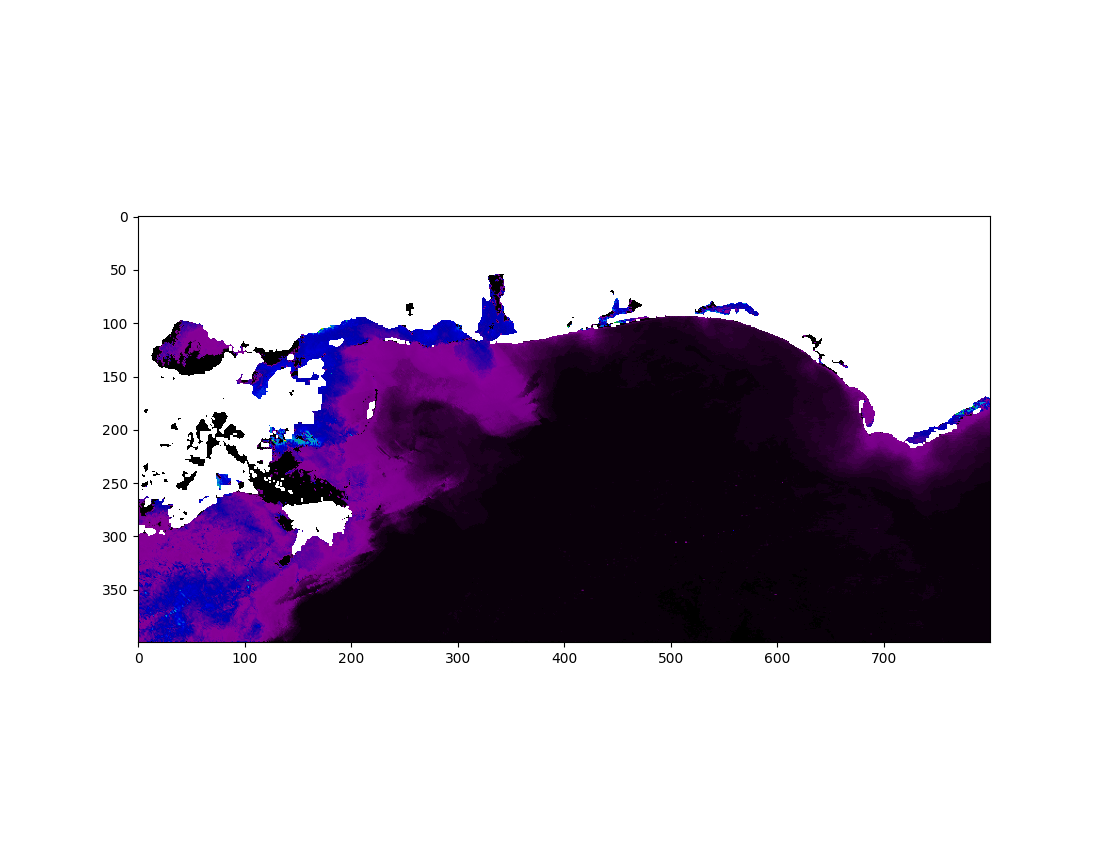 "NetCDF Native Read and plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging data files, saving results to /content/folderOnColab/007a_netcdf.jpg.")

NetCDF Native Read and plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging data files, 
saving results to /content/folderOnColab/007a_netcdf.jpg.

In [19]:
# Display Section 508 compliant image on the scrren with ALT text
try:
  make_accessible(plt, jinja2.Template(caption_text), len=len)
  rprint("\n")
  rprint(caption_text)
except (NameError, Exception) as e:
  process_exception(e)

## Get a Quick view of the data (Xarray libs)

In [20]:
matplt.use('Agg')

from matplotlib import pyplot as plt
fig, axes = plt.subplots(figsize=(FIGURE_WIDTH,FIGURE_HEIGHT));

# Save the plot to a file that can be pulled up at a later date.
target_filename=target_folder+os.sep+f"007a_xarray{IMG_EXT}";

# Create ALT text describing the image.
caption_text=f"Xarray Native Read, of the NetCDF, and plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging data files, saving results to {target_filename}.";

#notice the indexing of the array [time, depth, lat, lon], the ":" means everything
plt.imshow(the_xarray["chlor_a"][0][0][:][:],cmap='nipy_spectral')

plt.savefig(target_filename);
add_alt_text(target_folder+os.sep+f"007a_xarray{IMG_EXT}", caption_text);
rprint("Next display is a " + caption_text);


Next display is a Xarray Native Read, of the NetCDF, and plot of Chlorophyll-A for the Gulf of Mexico's MS Bight 
region after merging data files, saving results to /content/folderOnColab/007a_xarray.jpg.

![](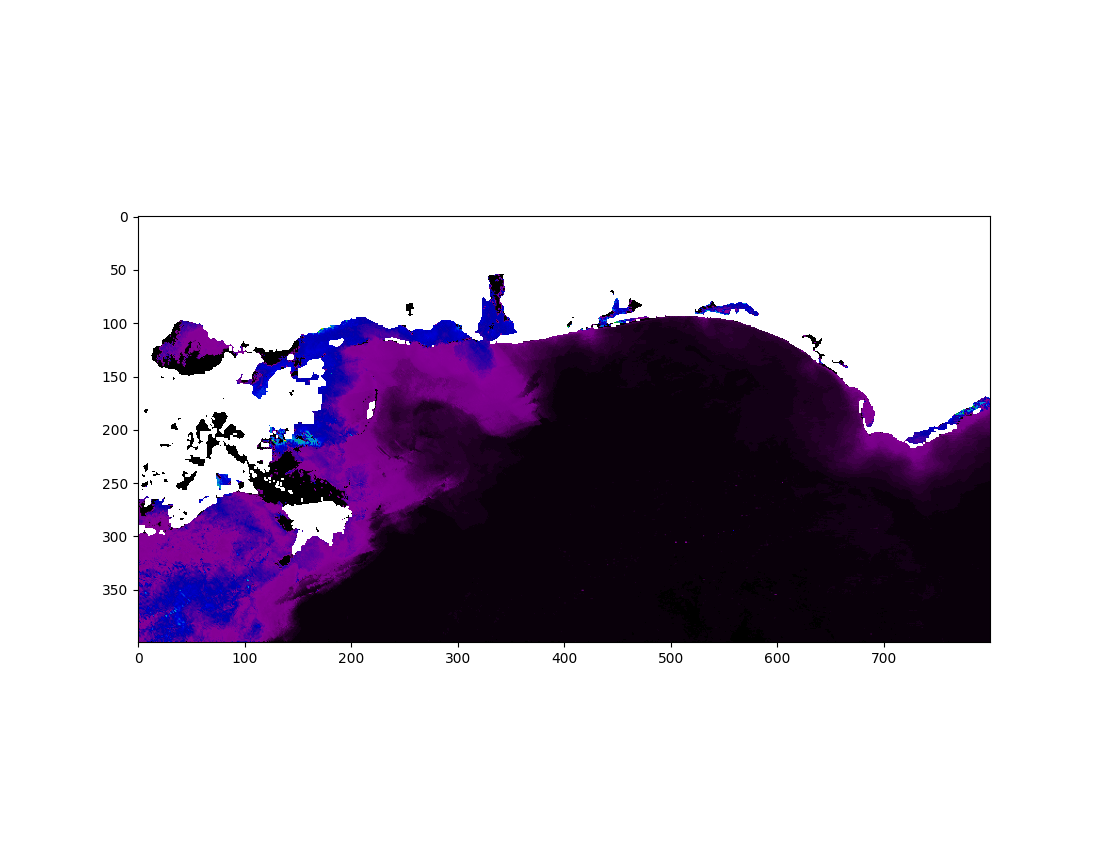 "Xarray Native Read, of the NetCDF, and plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging data files, saving results to /content/folderOnColab/007a_xarray.jpg.")

Xarray Native Read, of the NetCDF, and plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging
data files, saving results to /content/folderOnColab/007a_xarray.jpg.

In [21]:
# Display Section 508 compliant image on the scrren with ALT text
try:
  make_accessible(plt, jinja2.Template(caption_text), len=len)
  rprint("\n")
  rprint(caption_text)
except (NameError, Exception) as e:
  process_exception(e)

## Pandas Integration (this is why you use Xarray)

In [22]:
df=the_xarray.to_dataframe()

In [23]:
#quick view to show what's inside
df

chlor_a
lon      lat     depth time               
-90.5000 31.0000 1.0   2020-01-09      NaN
                 2.0   2020-01-09      NaN
                 3.0   2020-01-09      NaN
                 4.0   2020-01-09      NaN
                 5.0   2020-01-09      NaN
...                                    ...
-84.4978 28.3833 25.0  2020-01-09   0.3237
                 26.0  2020-01-09   0.3237
                 27.0  2020-01-09   0.3237
                 28.0  2020-01-09   0.3237
                 29.0  2020-01-09   0.3237

In [25]:
#CLOSE ALL FILES
rprint("Closing out NetCDF files.")
try:
    rprint("Closing NetCDF.")
    the_netcdf.close()
except Exception as e:
    process_exception(e)

try:
    rprint("Closing Xarray.")
    the_xarray.close()
except Exception as e:
    process_exception(e)


rprint("Finished " + str(VERSION_NAME) + ".")

Closing out NetCDF files.

Closing NetCDF.

RuntimeError('NetCDF: Not a valid ID')

Closing Xarray.

Finished XARRAY-READER.